# Maritime Trade: LSTM
## Train 2019 Test 2020 & Train2020 Test 2019

## Set Up Environment, Read Data, Split Train/Test Sets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install Tensorflow==2.5.0
!pip install category_encoders
import os
import random
import numpy as np
from numpy import concatenate
import warnings
import pandas as pd
import category_encoders as ce
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
%tensorflow_version 2.5.0
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
my_dpi = 96
print('TensorFlow version: {}'.format(tf.__version__))
print('Eager execution is: {}'.format(tf.executing_eagerly()))
print('Keras version: {}'.format(tf.keras.__version__))
print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))

     |████████████████████████████████| 454.3 MB 16 kB/s 
     |████████████████████████████████| 1.2 MB 64.2 MB/s 
     |████████████████████████████████| 4.0 MB 68.0 MB/s 
     |████████████████████████████████| 462 kB 47.7 MB/s 
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.39.0
    Uninstalling grpcio-1.39.0:
      Successfully uninstalled grpcio-1.39.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: Tensorflow
    Found existing installation: tensorflow 2.6.0
    Uninstalling tensorflow-2.6.0:
      Successfully uninstalled tensorflow-2.6.0
     |████████████████████████████████| 80 kB 5.6 MB/s 


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.5.0`. This will be interpreted as: `2.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.
TensorFlow version: 2.5.0
Eager execution is: True
Keras version: 2.5.0
Num GPUs Available:  0


In [ ]:
# Set seed for reproducibility
def init_seeds(seed=2019):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    session_conf = tf.compat.v1.ConfigProto()
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                                            inter_op_parallelism_threads=1)
    os.environ['TF_CUDNN_DETERMINISTIC'] = 'True'
    os.environ['TF_DETERMINISTIC_OPS'] = 'True'

    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),
                                config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)
    return sess

In [ ]:
init_seeds(seed=2019)

In [ ]:
%cd /content/drive/MyDrive/MaritimeTrade/Data/

/content/drive/MyDrive/MaritimeTrade/Data


In [ ]:
# Read data
df = pd.read_csv('combined_trade_final_LSTM.csv', low_memory=False)
print('Number of rows and columns:', df.shape)

Number of rows and columns: (6633785, 20)


In [ ]:
# Convert
df['DateTime']= pd.to_datetime(df['DateTime'])
df['DateTime_YearWeek'] = df['DateTime'].dt.strftime('%Y-w%U')

# Drop time and COVID-19 vars
df = df.drop(['DateTime'], axis=1)

In [ ]:
# X,y for encoding
X = df.drop(['Metric_Tons'], axis=1)
y = df['Metric_Tons']

df = pd.concat([X, y], axis=1)

# Sort data chronologically
df = df.sort_values('DateTime_YearWeek')

# Set YearWeek in the index
df = df.set_index('DateTime_YearWeek')

In [ ]:
# X,y for encoding
X = df.drop(['Metric_Tons'], axis=1)
y = df['Metric_Tons']

In [ ]:
# Encode variables using ranking - ordinal
ce_ord = ce.OrdinalEncoder(cols = ['foreign_company_size', 'us_company_size'])
X = ce_ord.fit_transform(X)

In [ ]:
# Convert remaining qualitative vars to dummy vars
X = pd.get_dummies(X, prefix=['HS_Group_Name', 'Container_LCL/FCL',
                              'Foreign_Country_Region',
                              'US_Port_Coastal_Region',
                              'Trade_Direction', 'Container_Type_Dry'],
                   columns=['HS_Group_Name', 'Container_LCL/FCL',
                            'Foreign_Country_Region',
                            'US_Port_Coastal_Region',
                            'Trade_Direction', 'Container_Type_Dry'])

df = pd.concat([X, y], axis=1)
print(df.shape)

(6633785, 42)


In [ ]:
# Examine year for the number per year to be used for train/test sets
df[['Year']].value_counts()

Year
2019    3368492
2020    3265293
dtype: int64

In [ ]:
# Drop year
df = df.drop(['Year'], axis=1)
df.shape

(6633785, 41)

In [ ]:
# Prepare data for LSTM
# Convert series to supervised learning
def series_to_supervised(dat, n_in=1, n_out=1, dropnan=True):

		n_vars = 1 if type(dat) is list else dat.shape[1]
		df = pd.DataFrame(dat)
		cols, names = list(), list()

		# Input sequence (t-n, ... t-1)
		for i in range(n_in, 0, -1):
				cols.append(df.shift(i))
				names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

		# Forecast sequence (t, t+1, ... t+n)
		for i in range(0, n_out):
				cols.append(df.shift(-i))
				if i == 0:
						names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
				else:
						names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

		# Concatenate
		agg = pd.concat(cols, axis=1)
		agg.columns = names

		# Drop rows with NaN values
		if dropnan:
				agg.dropna(inplace=True)
				return agg

# Load df
dataset = df
values = dataset.values

# Convert all to float
values = values.astype('float32')

# Normalize features
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)

# Frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,
                                58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,
																74,75,76,77,78,79,80,81]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)     var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.000280  5.305452e-07        0.0        0.0   0.044248   0.003732   
2   0.046162  4.439152e-05        0.2        0.0   0.044248   0.007459   
3   0.025281  2.431148e-05        0.2        0.0   0.044248   0.007459   
4   0.015281  1.469459e-05        0.0        0.0   0.044248   0.007459   
5   0.016601  1.596402e-05        0.0        0.0   0.044248   0.007459   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var11(t-1)  var12(t-1)  \
1        0.0        0.0     0.1250         0.0    0.000004    0.301587   
2        0.0        0.0     0.0625         0.0    0.000004    0.492064   
3        0.0        0.0     0.0625         0.0    0.000004    0.492064   
4        0.0        0.0     0.0625         0.0    0.000004    0.492064   
5        0.0        0.0     0.0625         0.0    0.000004    0.492064   

   var13(t-1)  var14(t-1)  var15(t-1)  var16(t-1)  var17(t-1)  var18(t-1)  \
1         0.0         0.0        

In [ ]:
# Define fit model for 2019
# Split into train and test sets
values = reframed.values
n_train_hours = 3368492
train = values[:n_train_hours,:]
test = values[n_train_hours:,:]

# Split into input and outputs
train_X, train_y = train[:,:-1], train[:,-1]
test_X, test_y = test[:,:-1], test[:,-1]

# Reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(3368492, 1, 41) (3368492,) (3265292, 1, 41) (3265292,)


## Batch Size = 16

In [ ]:
# LSTM Model
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', metrics=['mse'], optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                18400     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 18,451
Trainable params: 18,451
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%cd /content/drive/MyDrive/MaritimeTrade/Models/DL/LSTM/Models

# Set logs
log_folder = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

%load_ext tensorboard

# Set up callbacks
filepath = 'weights_only_train2019_test2020_n50_b16_epochs30.h5'

checkpoint_dir = os.path.dirname(filepath)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_folder,
                                                      histogram_freq=1)

callbacks_list = [EarlyStopping(monitor='loss', patience=3),
                  ModelCheckpoint(filepath, monitor='mse',
                                  save_best_only=True, mode='min'),
                  tensorboard_callback]

In [ ]:
# Train Model
history = model.fit(train_X, train_y, epochs=30, batch_size=16, shuffle=False,
                    callbacks=callbacks_list)

Epoch 1/30
210531/210531 [==============================] - 346s 2ms/step - loss: 0.0560 - mse: 0.0152
Epoch 2/30
210531/210531 [==============================] - 337s 2ms/step - loss: 0.0555 - mse: 0.0151
Epoch 3/30
210531/210531 [==============================] - 336s 2ms/step - loss: 0.0554 - mse: 0.0151
Epoch 4/30
210531/210531 [==============================] - 335s 2ms/step - loss: 0.0553 - mse: 0.0151
Epoch 5/30
210531/210531 [==============================] - 334s 2ms/step - loss: 0.0553 - mse: 0.0151
Epoch 6/30
210531/210531 [==============================] - 334s 2ms/step - loss: 0.0552 - mse: 0.0150
Epoch 7/30
210531/210531 [==============================] - 335s 2ms/step - loss: 0.0552 - mse: 0.0150
Epoch 8/30
210531/210531 [==============================] - 338s 2ms/step - loss: 0.0551 - mse: 0.0150
Epoch 9/30
210531/210531 [==============================] - 340s 2ms/step - loss: 0.0551 - mse: 0.0150
Epoch 10/30
210531/210531 [==============================] - 336s 2ms/ste

In [ ]:
model.save('./Model_50neuron_batch16_30epochs_train2019_tf.h5',
           save_format='tf')

# Load model for more training or later use
#filepath = 'weights_only_train2019_test2020_n50_b16_epochs30.h5'
#loaded_model = tf.keras.models.load_model('./Model_50neuron_batch16_30epochs_train2019_tf')
#model.load_weights(filepath)

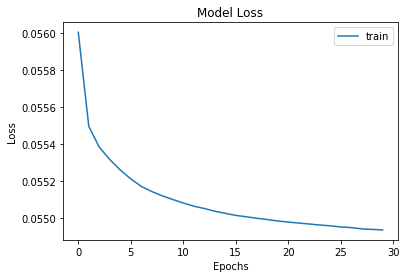

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot loss over epochs
plt.title('Model Loss')
plt.plot(history.history['loss'], label='train')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()
plt.savefig('Train2019_batch16_Epochs_Loss_Updated.png', dpi=my_dpi*10,
            bbox_inches='tight')

In [ ]:
# Make Predictions on Train
# Create empty table with 41 fields
train_predict = model.predict(train_X)
train_predict_dataset_like = np.zeros(shape=(len(train_predict), 41))

# Predicted values fill table
train_predict_dataset_like[:,0] = train_predict[:,0]

# Inverse transform and then select the right field
train_predict = scaler.inverse_transform(train_predict_dataset_like)[:,0]

print('Train Mean Absolute Error:', mean_absolute_error(train_y[:],
                                                        train_predict[:]))
print('Train Root Mean Squared Error:', np.sqrt(mean_squared_error(train_y[:],
                                                                   train_predict[:])))

Train Mean Absolute Error: 14.191485285712556
Train Root Mean Squared Error: 17.070247567152276


In [ ]:
# Make Predictions on Test
test_predict = model.predict(test_X)
test_predict_dataset_like = np.zeros(shape=(len(test_predict), 41))

# Invert predictions
test_predict_dataset_like[:,0] = test_predict[:,0]

# Inverse transform and then select the right field
test_predict = scaler.inverse_transform(test_predict_dataset_like)[:,0]

print('Test Mean Absolute Error:', mean_absolute_error(test_y[:],
                                                       test_predict[:]))
print('Test Root Mean Squared Error:', np.sqrt(mean_squared_error(test_y[:],
                                                                  test_predict[:])))

Test Mean Absolute Error: 12.788219180979366
Test Root Mean Squared Error: 15.699453759433998


In [ ]:
# Make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# Invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:,1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# Invert scaling for actual test data
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:,1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [ ]:
# Actual/Predicted maximum, average and minimum metric tonnage
print('Maximum Metric Tons:', np.amax(y_test))
print('Predicted Max Metric Tons:', np.amax(pred_test))
print('\nAverage Metric Tons:', np.average(y_test))
print('Predicted Average Metric Tons:', np.average(pred_test))
print('\nMinimum Metric Tons:', np.amin(y_test))
print('Predicted Minimum Metric Tons:', np.amin(pred_test))

Maximum Metric Tons: 249.99
Predicted Max Metric Tons: 637.048

Average Metric Tons: 21.535204
Predicted Average Metric Tons: 10.872106

Minimum Metric Tons: 0.0
Predicted Minimum Metric Tons: -153.2701


In [ ]:
# Calculate RMSE
print('Mean Absolute Error (MAE): %3f' % mean_absolute_error(inv_y, inv_yhat))
print('Mean Square Error (MSE): %3f' % mean_squared_error(inv_y, inv_yhat))

Mean Absolute Error (MAE): 15.287888
Mean Square Error (MSE): 992.176208


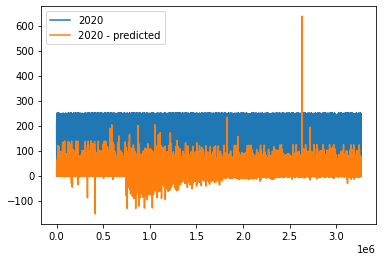

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot actual vs predicted metric tonnage
plt.plot(inv_y, label='2020')
plt.plot(inv_yhat, label='2020 - predicted')
plt.legend()
plt.show()
plt.savefig('Train2019_batch16_Epochs_ActVersusPred_Updated.png',
            dpi=my_dpi*10, bbox_inches='tight')

In [ ]:
data = [[2019, 16, np.amax(y_test), np.amax(pred_test), np.average(y_test),
         np.average(pred_test),np.amin(y_test),np.amin(pred_test)]]

df = pd.DataFrame(data, columns=['Year', 'BatchSize', 'Maximum Metric Tons',
                                 'Predicted Maximum Metric Tons',
                                 'Average Metric Tons',
                                 'Predicted Average Metric Tons',
                                 'Minimum Metric Tons',
                                 'Predicted Minimum Metric Tons'])

## Batch Size = 8

In [ ]:
# Set up callbacks
filepath = 'weights_only_train2019_test2020_n50_b8_epochs30.h5'

checkpoint_dir = os.path.dirname(filepath)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_folder,
                                                      histogram_freq=1)

callbacks_list = [EarlyStopping(monitor='loss', patience=3),
                  ModelCheckpoint(filepath, monitor='mse',
                                  save_best_only=True, mode='min'),
                  tensorboard_callback]

In [ ]:
# Train Model
history = model.fit(train_X, train_y, epochs=30, batch_size=8, shuffle=False,
                    callbacks=callbacks_list)

Epoch 1/30
421062/421062 [==============================] - 669s 2ms/step - loss: 0.0559 - mse: 0.0152
Epoch 2/30
421062/421062 [==============================] - 660s 2ms/step - loss: 0.0555 - mse: 0.0151
Epoch 3/30
421062/421062 [==============================] - 659s 2ms/step - loss: 0.0554 - mse: 0.0151
Epoch 4/30
421062/421062 [==============================] - 661s 2ms/step - loss: 0.0553 - mse: 0.0151
Epoch 5/30
421062/421062 [==============================] - 660s 2ms/step - loss: 0.0553 - mse: 0.0151
Epoch 6/30
421062/421062 [==============================] - 658s 2ms/step - loss: 0.0552 - mse: 0.0151
Epoch 7/30
421062/421062 [==============================] - 657s 2ms/step - loss: 0.0552 - mse: 0.0150
Epoch 8/30
421062/421062 [==============================] - 667s 2ms/step - loss: 0.0552 - mse: 0.0150
Epoch 9/30
421062/421062 [==============================] - 652s 2ms/step - loss: 0.0552 - mse: 0.0150
Epoch 10/30
421062/421062 [==============================] - 652s 2ms/ste

In [ ]:
model.save('./Model_50neuron_batch8_30epochs_train2019_tf.h5',
           save_format='tf')

# Load model for more training or later use
#filepath = 'weights_only_train2019_test2020_n50_b8_epochs30.h5'
#loaded_model = tf.keras.models.load_model('./Model_50neuron_batch8_30epochs_train2019_tf')
#model.load_weights(filepath)

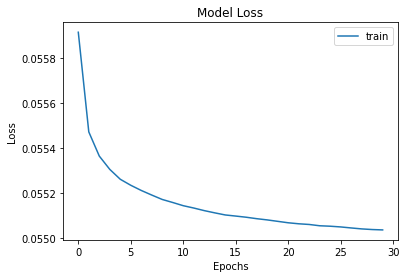

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot loss over epochs
plt.title('Model Loss')
plt.plot(history.history['loss'], label='train')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()
plt.savefig('Train2019_batch8_Epochs_Loss_Updated.png', dpi=my_dpi*10,
            bbox_inches='tight')

In [ ]:
# Make Predictions on Train
# Create empty table with 41 fields
train_predict = model.predict(train_X)
train_predict_dataset_like = np.zeros(shape=(len(train_predict), 41))

# Predicted values fill table
train_predict_dataset_like[:,0] = train_predict[:,0]

# Inverse transform and then select the right field
train_predict = scaler.inverse_transform(train_predict_dataset_like)[:,0]

print('Train Mean Absolute Error:', mean_absolute_error(train_y[:],
                                                        train_predict[:]))
print('Train Root Mean Squared Error:', np.sqrt(mean_squared_error(train_y[:],
                                                                   train_predict[:])))

Train Mean Absolute Error: 14.527630909053016
Train Root Mean Squared Error: 17.37103300923245


In [ ]:
# Make Predictions on Test
test_predict = model.predict(test_X)
test_predict_dataset_like = np.zeros(shape=(len(test_predict), 41))

# Invert predictions
test_predict_dataset_like[:,0] = test_predict[:,0]

# Inverse transform and then select the right field
test_predict = scaler.inverse_transform(test_predict_dataset_like)[:,0]

print('Test Mean Absolute Error:', mean_absolute_error(test_y[:],
                                                       test_predict[:]))
print('Test Root Mean Squared Error:', np.sqrt(mean_squared_error(test_y[:],
                                                                  test_predict[:])))

Test Mean Absolute Error: 48.90412796388756
Test Root Mean Squared Error: 116.52741560434524


In [ ]:
# Make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# Invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:,1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# Invert scaling for actual test data
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:,1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [ ]:
# Actual/Predicted maximum, average and minimum metric tonnage
print('Maximum Metric Tons:', np.amax(y_test))
print('Predicted Max Metric Tons:', np.amax(pred_test))
print('\nAverage Metric Tons:', np.average(y_test))
print('Predicted Average Metric Tons:', np.average(pred_test))
print('\nMinimum Metric Tons:', np.amin(y_test))
print('Predicted Minimum Metric Tons:', np.amin(pred_test))

Maximum Metric Tons: 249.99
Predicted Max Metric Tons: 1621.6544

Average Metric Tons: 21.535204
Predicted Average Metric Tons: -24.67689

Minimum Metric Tons: 0.0
Predicted Minimum Metric Tons: -2013.7032


In [ ]:
# Calculate RMSE
print('Mean Absolute Error (MAE): %3f' % mean_absolute_error(inv_y, inv_yhat))
print('Mean Square Error (MSE): %3f' % mean_squared_error(inv_y, inv_yhat))

Mean Absolute Error (MAE): 53.372280
Mean Square Error (MSE): 15196.197266


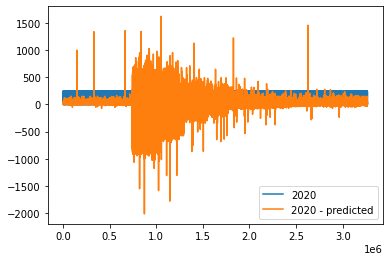

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot actual vs predicted metric tonnage
plt.plot(inv_y, label='2020')
plt.plot(inv_yhat, label='2020 - predicted')
plt.legend()
plt.show()
plt.savefig('Train2019_batch8_Epochs_ActVersusPred_Updated.png', dpi=my_dpi*10,
            bbox_inches='tight')

In [ ]:
data = [[2019, 8, np.amax(y_test), np.amax(pred_test), np.average(y_test),
         np.average(pred_test),np.amin(y_test),np.amin(pred_test)]]

df1 = pd.DataFrame(data, columns=['Year', 'BatchSize', 'Maximum Metric Tons',
                                  'Predicted Maximum Metric Tons',
                                  'Average Metric Tons',
                                  'Predicted Average Metric Tons',
                                  'Minimum Metric Tons',
                                  'Predicted Minimum Metric Tons'])

df = pd.concat([df, df1])

## Batch Size = 4

In [ ]:
# Set up callbacks
filepath = 'weights_only_train2019_test2020_n50_b4_epochs30.h5'

checkpoint_dir = os.path.dirname(filepath)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_folder,
                                                      histogram_freq=1)

callbacks_list = [EarlyStopping(monitor='loss', patience=3),
                  ModelCheckpoint(filepath, monitor='mse',
                                  save_best_only=True, mode='min'),
                  tensorboard_callback]

In [ ]:
# Train Model
history = model.fit(train_X, train_y, epochs=30, batch_size=4, shuffle=False,
                    callbacks=callbacks_list)

Epoch 1/30
842123/842123 [==============================] - 1311s 2ms/step - loss: 0.0559 - mse: 0.0152
Epoch 2/30
842123/842123 [==============================] - 1273s 2ms/step - loss: 0.0555 - mse: 0.0151
Epoch 3/30
842123/842123 [==============================] - 1271s 2ms/step - loss: 0.0554 - mse: 0.0151
Epoch 4/30
842123/842123 [==============================] - 1276s 2ms/step - loss: 0.0554 - mse: 0.0151
Epoch 5/30
842123/842123 [==============================] - 1274s 2ms/step - loss: 0.0554 - mse: 0.0150
Epoch 6/30
842123/842123 [==============================] - 1273s 2ms/step - loss: 0.0553 - mse: 0.0150
Epoch 7/30
842123/842123 [==============================] - 1270s 2ms/step - loss: 0.0553 - mse: 0.0150
Epoch 8/30
842123/842123 [==============================] - 1260s 1ms/step - loss: 0.0553 - mse: 0.0150
Epoch 9/30
842123/842123 [==============================] - 1267s 2ms/step - loss: 0.0553 - mse: 0.0150
Epoch 10/30
842123/842123 [==============================] - 127

In [ ]:
model.save('./Model_50neuron_batch4_30epochs_train2019_tf.h5',
           save_format='tf')

# Load model for more training or later use
#filepath = 'weights_only_train2019_test2020_n50_b4_epochs30.h5'
#loaded_model = tf.keras.models.load_model('./Model_50neuron_batch4_30epochs_train2019_tf')
#model.load_weights(filepath)

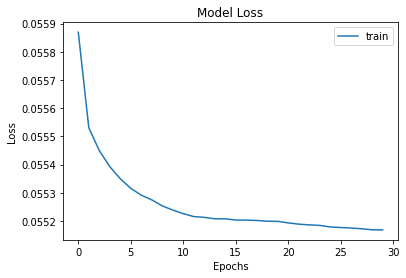

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot loss over epochs
plt.title('Model Loss')
plt.plot(history.history['loss'], label='train')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.savefig('Train2019_batch4_Epochs_Loss_Updated.png', dpi=my_dpi*10,
            bbox_inches='tight')
plt.show()

In [ ]:
# Make Predictions on Train
# Create empty table with 41 fields
train_predict = model.predict(train_X)
train_predict_dataset_like = np.zeros(shape=(len(train_predict), 41))

# Predicted values fill table
train_predict_dataset_like[:,0] = train_predict[:,0]

# Inverse transform and then select the right field
train_predict = scaler.inverse_transform(train_predict_dataset_like)[:,0]

print('Train Mean Absolute Error:', mean_absolute_error(train_y[:],
                                                        train_predict[:]))
print('Train Root Mean Squared Error:', np.sqrt(mean_squared_error(train_y[:],
                                                                   train_predict[:])))

Train Mean Absolute Error: 14.894021679834943
Train Root Mean Squared Error: 17.93181664079699


In [ ]:
# Make Predictions on Test
test_predict = model.predict(test_X)
test_predict_dataset_like = np.zeros(shape=(len(test_predict), 41))

# Invert predictions
test_predict_dataset_like[:,0] = test_predict[:,0]

# Inverse transform and then select the right field
test_predict = scaler.inverse_transform(test_predict_dataset_like)[:,0]

print('Test Mean Absolute Error:', mean_absolute_error(test_y[:],
                                                       test_predict[:]))
print('Test Root Mean Squared Error:', np.sqrt(mean_squared_error(test_y[:],
                                                                  test_predict[:])))

Test Mean Absolute Error: 92.64103135817602
Test Root Mean Squared Error: 273.5696375397255


In [ ]:
# Make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# Invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:,1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# Invert scaling for actual test data
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:,1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [ ]:
# Actual/Predicted maximum, average and minimum metric tonnage
print('Maximum Metric Tons:', np.amax(y_test))
print('Predicted Max Metric Tons:', np.amax(pred_test))
print('\nAverage Metric Tons:', np.average(y_test))
print('Predicted Average Metric Tons:', np.average(pred_test))
print('\nMinimum Metric Tons:', np.amin(y_test))
print('Predicted Minimum Metric Tons:', np.amin(pred_test))

Maximum Metric Tons: 249.99
Predicted Max Metric Tons: 3583.0906

Average Metric Tons: 21.535204
Predicted Average Metric Tons: -40.82472

Minimum Metric Tons: 0.0
Predicted Minimum Metric Tons: -2778.3926


In [ ]:
# Calculate RMSE
print('Mean Absolute Error (MAE): %3f' % mean_absolute_error(inv_y, inv_yhat))
print('Mean Square Error (MSE): %3f' % mean_squared_error(inv_y, inv_yhat))

Mean Absolute Error (MAE): 93.193565
Mean Square Error (MSE): 76225.539062


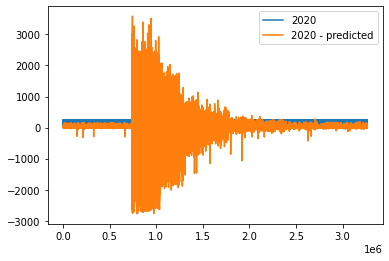

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot actual vs predicted metric tonnage
plt.plot(inv_y, label='2020')
plt.plot(inv_yhat, label='2020 - predicted')
plt.legend()
plt.savefig('Train2019_batch4_Epochs_ActVersusPred_Updated.png',
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

In [ ]:
data = [[2019, 4, np.amax(y_test), np.amax(pred_test), np.average(y_test),
         np.average(pred_test),np.amin(y_test),np.amin(pred_test)]]

df = pd.DataFrame(data, columns=['Year', 'BatchSize', 'Maximum Metric Tons',
                                 'Predicted Maximum Metric Tons',
                                 'Average Metric Tons',
                                 'Predicted Average Metric Tons',
                                 'Minimum Metric Tons',
                                 'Predicted Minimum Metric Tons'])

df = pd.concat([df, df1])

## Batch Size = 2

In [ ]:
# Set up callbacks
log_folder = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

%load_ext tensorboard

filepath = 'weights_only_train2019_test2020_n50_b2_epochs30.h5'
checkpoint_dir = os.path.dirname(filepath)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_folder,
                                                      histogram_freq=1)

callbacks_list = [EarlyStopping(monitor='loss', patience=3),
                  ModelCheckpoint(filepath, monitor='mse',
                                  save_best_only=True, mode='min'),
                  tensorboard_callback]

In [ ]:
# Train Model
history = model.fit(train_X, train_y, epochs=30, batch_size=2, shuffle=False,
                    callbacks=callbacks_list)

Epoch 1/30
1684246/1684246 [==============================] - 2976s 2ms/step - loss: 0.0558 - mse: 0.0151
Epoch 2/30
1684246/1684246 [==============================] - 2933s 2ms/step - loss: 0.0555 - mse: 0.0151
Epoch 3/30
1684246/1684246 [==============================] - 2934s 2ms/step - loss: 0.0555 - mse: 0.0150
Epoch 4/30
1684246/1684246 [==============================] - 2929s 2ms/step - loss: 0.0554 - mse: 0.0150
Epoch 5/30
1684246/1684246 [==============================] - 2937s 2ms/step - loss: 0.0554 - mse: 0.0150
Epoch 6/30
1684246/1684246 [==============================] - 2938s 2ms/step - loss: 0.0554 - mse: 0.0150
Epoch 7/30
1684246/1684246 [==============================] - 2920s 2ms/step - loss: 0.0554 - mse: 0.0150
Epoch 8/30
1684246/1684246 [==============================] - 2931s 2ms/step - loss: 0.0554 - mse: 0.0150
Epoch 9/30
1684246/1684246 [==============================] - 2925s 2ms/step - loss: 0.0554 - mse: 0.0150
Epoch 10/30
1684246/1684246 [=================

In [ ]:
model.save('./Model_50neuron_batch2_30epochs_train2019_tf.h5',
           save_format='tf')

# Load model for more training or later use
#filepath = 'weights_only_train2019_test2020_n50_b2_epochs30.h5'
#loaded_model = tf.keras.models.load_model('./Model_50neuron_batch2_30epochs_train2019_tf')
#model.load_weights(filepath)

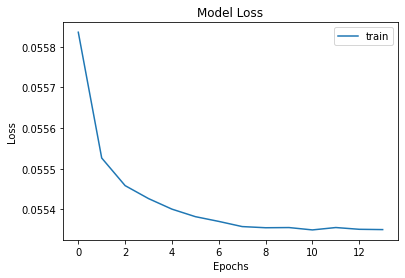

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot loss over epochs
plt.title('Model Loss')
plt.plot(history.history['loss'], label='train')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()
plt.savefig('Train2019_batch2_Epochs_Loss_Updated.png', dpi=my_dpi*10,
            bbox_inches='tight')

In [ ]:
# Make Predictions on Train
# Create empty table with 41 fields
train_predict = model.predict(train_X)
train_predict_dataset_like = np.zeros(shape=(len(train_predict), 41))

# Predicted values fill table
train_predict_dataset_like[:,0] = train_predict[:,0]

# Inverse transform and then select the right field
train_predict = scaler.inverse_transform(train_predict_dataset_like)[:,0]

print('Train Mean Absolute Error:', mean_absolute_error(train_y[:],
                                                        train_predict[:]))
print('Train Root Mean Squared Error:', np.sqrt(mean_squared_error(train_y[:],
                                                                   train_predict[:])))

Train Mean Absolute Error: 15.280872679572107
Train Root Mean Squared Error: 17.89666887148485


In [ ]:
# Make Predictions on Test
test_predict = model.predict(test_X)
test_predict_dataset_like = np.zeros(shape=(len(test_predict), 41))

# Invert predictions
test_predict_dataset_like[:,0] = test_predict[:,0]

# Inverse transform and then select the right field
test_predict = scaler.inverse_transform(test_predict_dataset_like)[:,0]

print('Test Mean Absolute Error:', mean_absolute_error(test_y[:],
                                                       test_predict[:]))
print('Test Root Mean Squared Error:', np.sqrt(mean_squared_error(test_y[:],
                                                                  test_predict[:])))

In [ ]:
# Make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# Invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:,1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# Invert scaling for actual test data
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:,1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [ ]:
# Actual/Predicted maximum, average and minimum metric tonnage
print('Maximum Metric Tons:', np.amax(y_test))
print('Predicted Max Metric Tons:', np.amax(pred_test))
print('\nAverage Metric Tons:', np.average(y_test))
print('Predicted Average Metric Tons:', np.average(pred_test))
print('\nMinimum Metric Tons:', np.amin(y_test))
print('Predicted Minimum Metric Tons:', np.amin(pred_test))

Maximum Metric Tons: 249.99
Predicted Max Metric Tons: 5749.582

Average Metric Tons: 21.535204
Predicted Average Metric Tons: -102.33338

Minimum Metric Tons: 0.0
Predicted Minimum Metric Tons: -4716.5093


In [ ]:
# Calculate RMSE
print('Mean Absolute Error (MAE): %3f' % mean_absolute_error(inv_y, inv_yhat))
print('Mean Square Error (MSE): %3f' % mean_squared_error(inv_y, inv_yhat))

Mean Absolute Error (MAE): 271.003937
Mean Square Error (MSE): 529086.687500


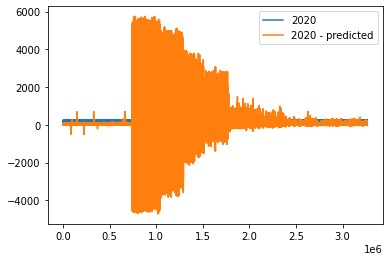

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot actual vs predicted metric tonnage
plt.plot(inv_y, label='2020')
plt.plot(inv_yhat, label='2020 - predicted')
plt.legend()
plt.show()
plt.savefig('Train2019_batch2_Epochs_ActVersusPred_Updated.png',
            dpi=my_dpi*10, bbox_inches='tight')

In [ ]:
data = [[2019, 2, np.amax(y_test), np.amax(pred_test), np.average(y_test),
         np.average(pred_test), np.amin(y_test), np.amin(pred_test)]]

df = pd.DataFrame(data, columns=['Year', 'BatchSize', 'Maximum Metric Tons',
                                 'Predicted Maximum Metric Tons',
                                 'Average Metric Tons',
                                 'Predicted Average Metric Tons',
                                 'Minimum Metric Tons',
                                 'Predicted Minimum Metric Tons'])

df = pd.concat([df, df1])
df.to_csv('LSTM_19_20_Results.csv')

## Graph Results from Train 2019 and Train 2020

In [ ]:
# Read csv with results
df = pd.read_csv('LSTM_19_20_Results.csv')
df

,Year,Batch Size,Maximum Metric Tons,Predicted Maximum Metric Tons,Average Metric Tons,Predicted Average Metric Tons,Minimum Metric Tons,Predicted Minimum Metric Tons
0,2020,16,249.99,247.87039,21.897873,15.626926,0,-254.637760
1,2020,8,249.99,180.05067,21.897873,16.335623,0,-116.713486
2,2020,4,249.99,518.87090,21.897873,18.322914,0,-459.725620
3,2020,2,249.99,326.99810,21.897873,21.541716,0,-136.166670
4,2019,16,249.99,637.04800,21.535204,10.872106,0,-153.270100
5,2019,8,249.99,1621.65440,21.535204,-24.676890,0,-2013.703200
6,2019,4,249.99,3583.09060,21.535204,-40.824720,0,-2778.392600
7,2019,2,249.99,5749.58200,21.535204,-102.333380,0,-4716.509300


In [ ]:
# Select predicted values
df_num = df[['Predicted Maximum Metric Tons', 'Predicted Average Metric Tons',
             'Predicted Minimum Metric Tons']]

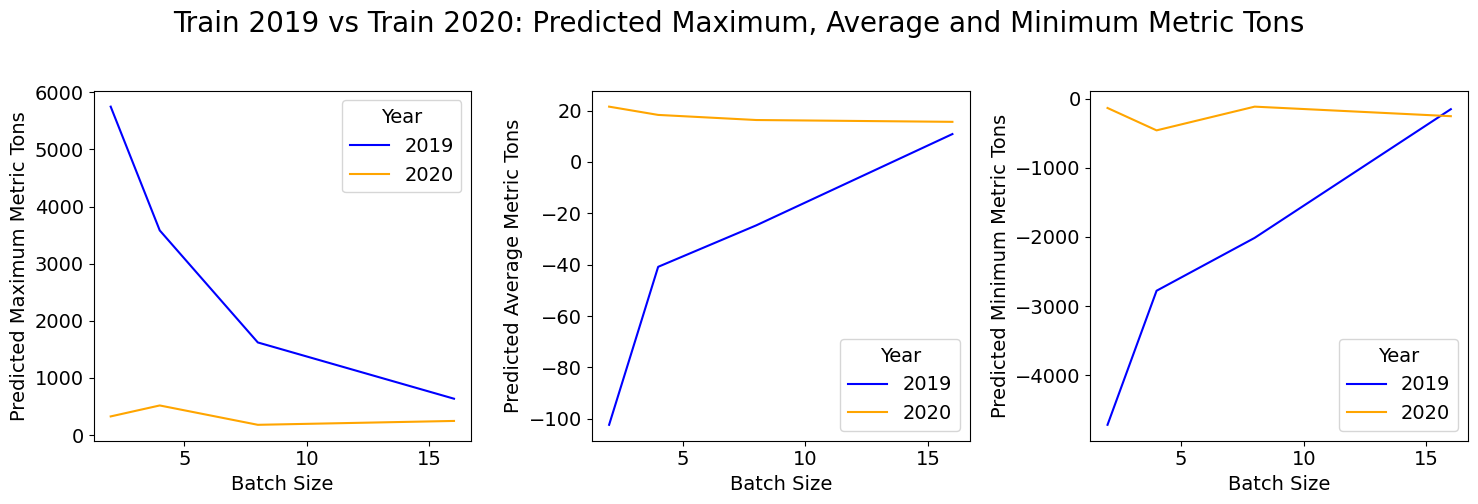

In [ ]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(1,3, figsize=(15,5))
fig.suptitle('Train 2019 vs Train 2020: Predicted Maximum, Average and Minimum Metric Tons',
             y=1.01, fontsize=20)
for variable, subplot in zip(df_num, ax.flatten()):
    a = sns.lineplot(data=df, x=df['Batch Size'], y=df_num[variable],
                     hue=df.Year,  palette=['blue', 'orange'], ax=subplot)
fig.tight_layout()
fig.savefig('Train1920_PredictedMaxAvgMinMetricTons.png',
          dpi=my_dpi*10, bbox_inches='tight')
plt.show();